In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [18]:
def data_los_cleanup(adm_csv= " " , patients_csv= " ",
                      diagcode_csv=" ", icu_csv= " ", verbose = True):
    
    import pandas as pd
    import numpy as np
    
    # Import CSV tables
    df = pd.read_csv(adm_csv)
    df_pat = pd.read_csv(patients_csv)
    df_diagcode = pd.read_csv(diagcode_csv)
    df_icu = pd.read_csv(icu_csv)
    if verbose: 
        print('(1/5) Completed .csv imports')
        
    # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    df['admittime'] = pd.to_datetime(df['admittime'])
    df['dischtime'] = pd.to_datetime(df['dischtime'])
    # Convert timedelta type into float 'days', 86400 seconds in a day
    df['LOS'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400
    
    # Drop columns that are not needed for next steps
    df.drop(columns=['dischtime', 'row_id', 
                    'edregtime', 'edouttime', 'hospital_expire_flag',
                    'has_chartevents_data'], inplace=True)
    
    # Track patients who died were DOA 
    df['DECEASED'] = df['deathtime'].notnull().map({True:1, False:0})
    
    # Hospital LOS metrics
    actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
    actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 
    
    # Compress the number of ethnicity categories
    df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
    df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
    df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
    df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
    df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                             'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
    df['ethnicity'].loc[~df['ethnicity'].isin(df['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

    # Reduce categories to terms of religious or not
    df['religion'].loc[~df['religion'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

    # Re-categorize NaNs into 'Unknown'
    df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
    
    if verbose: 
        print('(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.')
        
    # Feature Engineering for ICD9 code categories
    # Filter out E and V codes since processing will be done on the numeric first 3 values
    df_diagcode['recode'] = df_diagcode['icd9_code']
    df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
    df_diagcode['recode'].fillna(value='999', inplace=True)
    df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
    df_diagcode['recode'] = df_diagcode['recode'].astype(int)
    
    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
                   (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
                   (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

    # Associated category names
    diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
                 4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
                 8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
                 12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
                 16: 'injury', 17: 'misc'}

    # Re-code in terms of integer
    for num, cat_range in enumerate(icd9_ranges):
        df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
                num, df_diagcode['recode'])

    # Convert integer to category name using diag_dict
    df_diagcode['recode'] = df_diagcode['recode']
    df_diagcode['Diagnosis_catagory'] = df_diagcode['recode'].replace(diag_dict)
    
    # Create list of diagnoses for each admission
    hadm_list = df_diagcode.groupby('hadm_id')['Diagnosis_catagory'].apply(list).reset_index()
    
    # Convert diagnoses list into hospital admission-item matrix
    hadm_item = pd.get_dummies(hadm_list['Diagnosis_catagory'].apply(pd.Series).stack())
    hadm_item = hadm_item.groupby(level=0).sum()
    
    # Join back with hadm_id, will merge with main admissions DF later
    hadm_item = hadm_item.join(hadm_list['hadm_id'], how="inner")

    # Merge with main admissions df
    df = df.merge(hadm_item, how='inner', on='hadm_id')
    
    if verbose: 
        print('(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.')
    
    # Feature Engineering for Age and Gender
    # Convert to datetime type
    df_pat['dob'] = pd.to_datetime(df_pat['dob'])
    df_pat = df_pat[['subject_id', 'dob', 'gender']]
    df = df.merge(df_pat, how='inner', on='subject_id')
    
    # Find the first admission time for each patient
    df_age_min = df[['subject_id', 'admittime']].groupby('subject_id').min().reset_index()
    df_age_min.columns = ['subject_id', 'admit_min']
    df = df.merge(df_age_min, how='outer', on='subject_id')
    
    # Age is decode by finding the difference in admission date and date of birth
    df['admit_min'] = pd.to_datetime(df['admit_min'])
    df['admit_year'] = df['admit_min'].dt.year

    df['dob'] = pd.to_datetime(df['dob'])
    df['dob_year'] = df['dob'].dt.year
    df['age_days'] = (df['admit_year'] - df['dob_year'])
    df['age'] = np.where(df['age_days'] > np.iinfo(np.int64).max, np.nan, df['age_days'] // 365)
    df['age'].isnull().sum()
    
    # Create age categories
    age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
    for num, cat_range in enumerate(age_ranges):
        df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
                num, df['age'])
    age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
    df['age'] = df['age'].replace(age_dict)
    
    # Re-map Gender to boolean type
    df['gender'].replace({'M': 0, 'F':1}, inplace=True)
    
    if verbose: 
        print('(4/5) Completed PATIENT.csv cleanup and feature engineering.')
    
    # Feature engineering for Intensive Care Unit (ICU) category
    # Reduce ICU categories to just ICU or nicu
    df_icu['first_careunit'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU', 'Cardiac Vascular Intensive Care Unit (CVICU)': 'ICU', 
                                  'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'ICU',
                                  'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'ICU'}, inplace=True)
    df_icu['Diagnosis catagory'] = df_icu['first_careunit']
    icu_list = df_icu.groupby('hadm_id')['Diagnosis catagory'].apply(list).reset_index()
    icu_item = pd.get_dummies(icu_list['Diagnosis catagory'].apply(pd.Series).stack())
    icu_item = icu_item.groupby(level=0).sum()
    icu_item[icu_item >= 1] = 1
    icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
    df = df.merge(icu_item, how='outer', on='hadm_id')
    
    # Cleanup NaNs
    df['ICU'].fillna(value=0, inplace=True)
    
    if verbose: 
        print('(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.')
        
    # Remove deceased persons as they will skew LOS result
    df = df[df['DECEASED'] == 0]

    # Remove LOS with negative number, likely entry form error
    df = df[df['LOS'] > 0]    
    
    # Drop unused columns, e.g. not used to predict LOS
    df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'admission_location',
                'discharge_location', 'language', 'admit_min', 'dob',
                'diagnosis', 'DECEASED', 'deathtime', 'admit_year', 'dob_year'], inplace=True)
    
    # prefix_cols = ['adm', 'ins', 'rel', 'eth', 'age', 'mar','gender']
    # dummy_cols = ['admission_type', 'insurance', 'religion',
    #              'ethnicity', 'age', 'marital_status','gender']
    #df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols, dtype=int)
    object_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=object_cols, dtype=int)

    
    df = df.dropna(axis=1)


    
    if verbose: 
        print('Data Preprocessing complete.')
    
    #df.to_csv(output)
    return df


In [14]:
df_clean = data_los_cleanup( adm_csv = r'C:\Users\nehas\OneDrive\Desktop\Projects\LOS-project\Data\mimic-iii-clinical-database-demo-1.4\ADMISSIONS.csv',
                                                                 patients_csv = r'C:\Users\nehas\OneDrive\Desktop\Projects\LOS-project\Data\mimic-iii-clinical-database-demo-1.4\PATIENTS.csv',
                                                                 diagcode_csv = r'C:\Users\nehas\OneDrive\Desktop\Projects\LOS-project\Data\mimic-iii-clinical-database-demo-1.4\DIAGNOSES_ICD.csv',
                                                                 icu_csv = r'C:\Users\nehas\OneDrive\Desktop\Projects\LOS-project\Data\mimic-iii-clinical-database-demo-1.4\ICUSTAYS.csv')

(1/5) Completed .csv imports
(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.
(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.
(4/5) Completed PATIENT.csv cleanup and feature engineering.
(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.
Data Preprocessing complete.


C:\Users\nehas\AppData\Local\Temp\ipykernel_12680\3849436763.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
C:\Users\nehas\AppData\Local\Temp\ipykernel_12680\3849436763.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [19]:
print(type(df_clean))

<class 'pandas.core.frame.DataFrame'>


In [16]:
def plot_missing_data(df): 
    missing_data = df.isnull().mean() * 100

    missing_data =missing_data[missing_data>0].sort_values(ascending=False)

    #Plot missing data 
    plt.figure(figsize=(10,6))
    missing_data.plot(kind='bar')
    plt.xlabel('Columns')
    plt.ylabel(' Percentage of missing data')
    plt.title('percentage of missing data in each column')
    plt.xticks(rotation=90)
    plt.show()

In [20]:
df_clean.isnull().sum(axis=0)

LOS                                           0
blood                                         0
circulatory                                   0
congenital                                    0
digestive                                     0
endocrine                                     0
genitourinary                                 0
infectious                                    0
injury                                        0
mental                                        0
misc                                          0
muscular                                      0
neoplasms                                     0
nervous                                       0
prenatal                                      0
respiratory                                   0
skin                                          0
gender                                        0
age_days                                      0
ICU                                           0
admission_type_AMBULATORY OBSERVATION   

In [23]:
df_clean.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER/UNKNOWN,ethnicity_UNKNOWN,ethnicity_WHITE,age_-1.0,age_newborn
0,4.561111,0.0,2.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,1,0,1
2,16.980556,1.0,2.0,0.0,1.0,2.0,1.0,0.0,11.0,1.0,...,0,0,0,0,0,0,0,1,0,1
3,12.027083,0.0,0.0,0.0,4.0,3.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1
4,9.615278,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,1,0,0,0,0,0,0,1,0,1
6,5.449306,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,...,1,0,0,0,1,0,0,0,0,1


In [25]:
def plot_feature_vs_target(df, target, features_per_figure=5):
    
    # Check if the target variable exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Target variable '{target}' not found in DataFrame columns.")
    
    # Drop the target column to get feature columns
    features = df.drop(columns=[target])
    
    # Determine the number of figures needed
    num_features = len(features.columns)
    num_figures = (num_features // features_per_figure) + (1 if num_features % features_per_figure > 0 else 0)
    
    for i in range(num_figures):
        plt.figure(figsize=(15, features_per_figure * 4))  # Adjust figure size
        start_idx = i * features_per_figure
        end_idx = min(start_idx + features_per_figure, num_features)
        feature_subset = features.columns[start_idx:end_idx]
        
        for j, feature in enumerate(feature_subset):
            plt.subplot(features_per_figure, 1, j + 1)
            sns.scatterplot(data=df, x=feature, y=target)
            plt.title(f'{feature} vs {target}')
            plt.xlabel(feature)
            plt.ylabel(target)
        
        plt.tight_layout()
        plt.show()


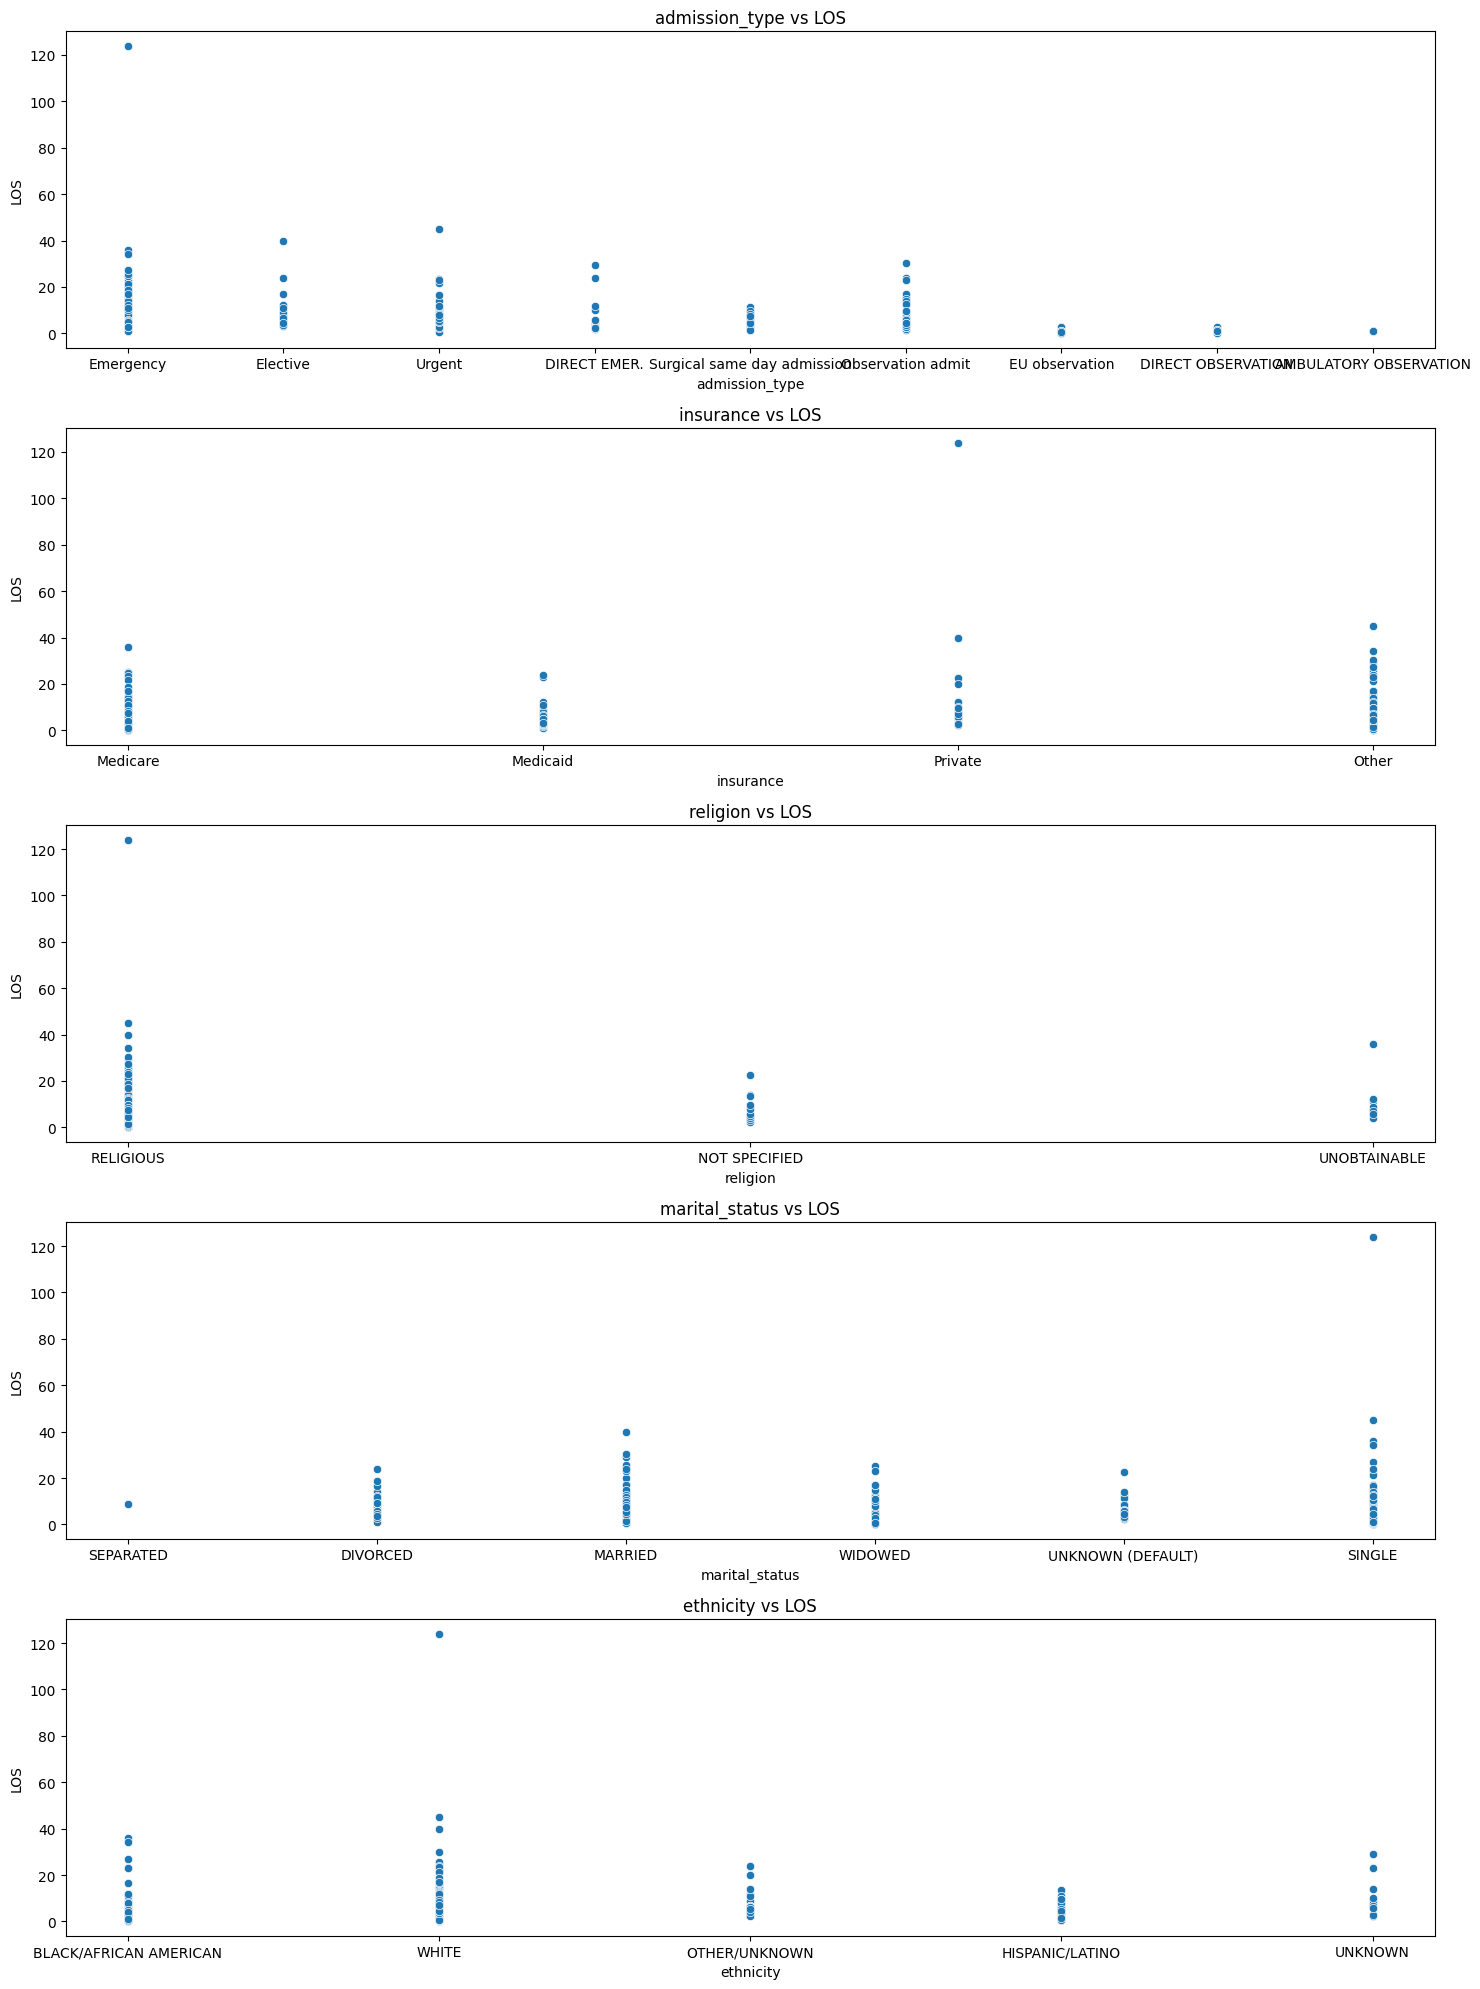

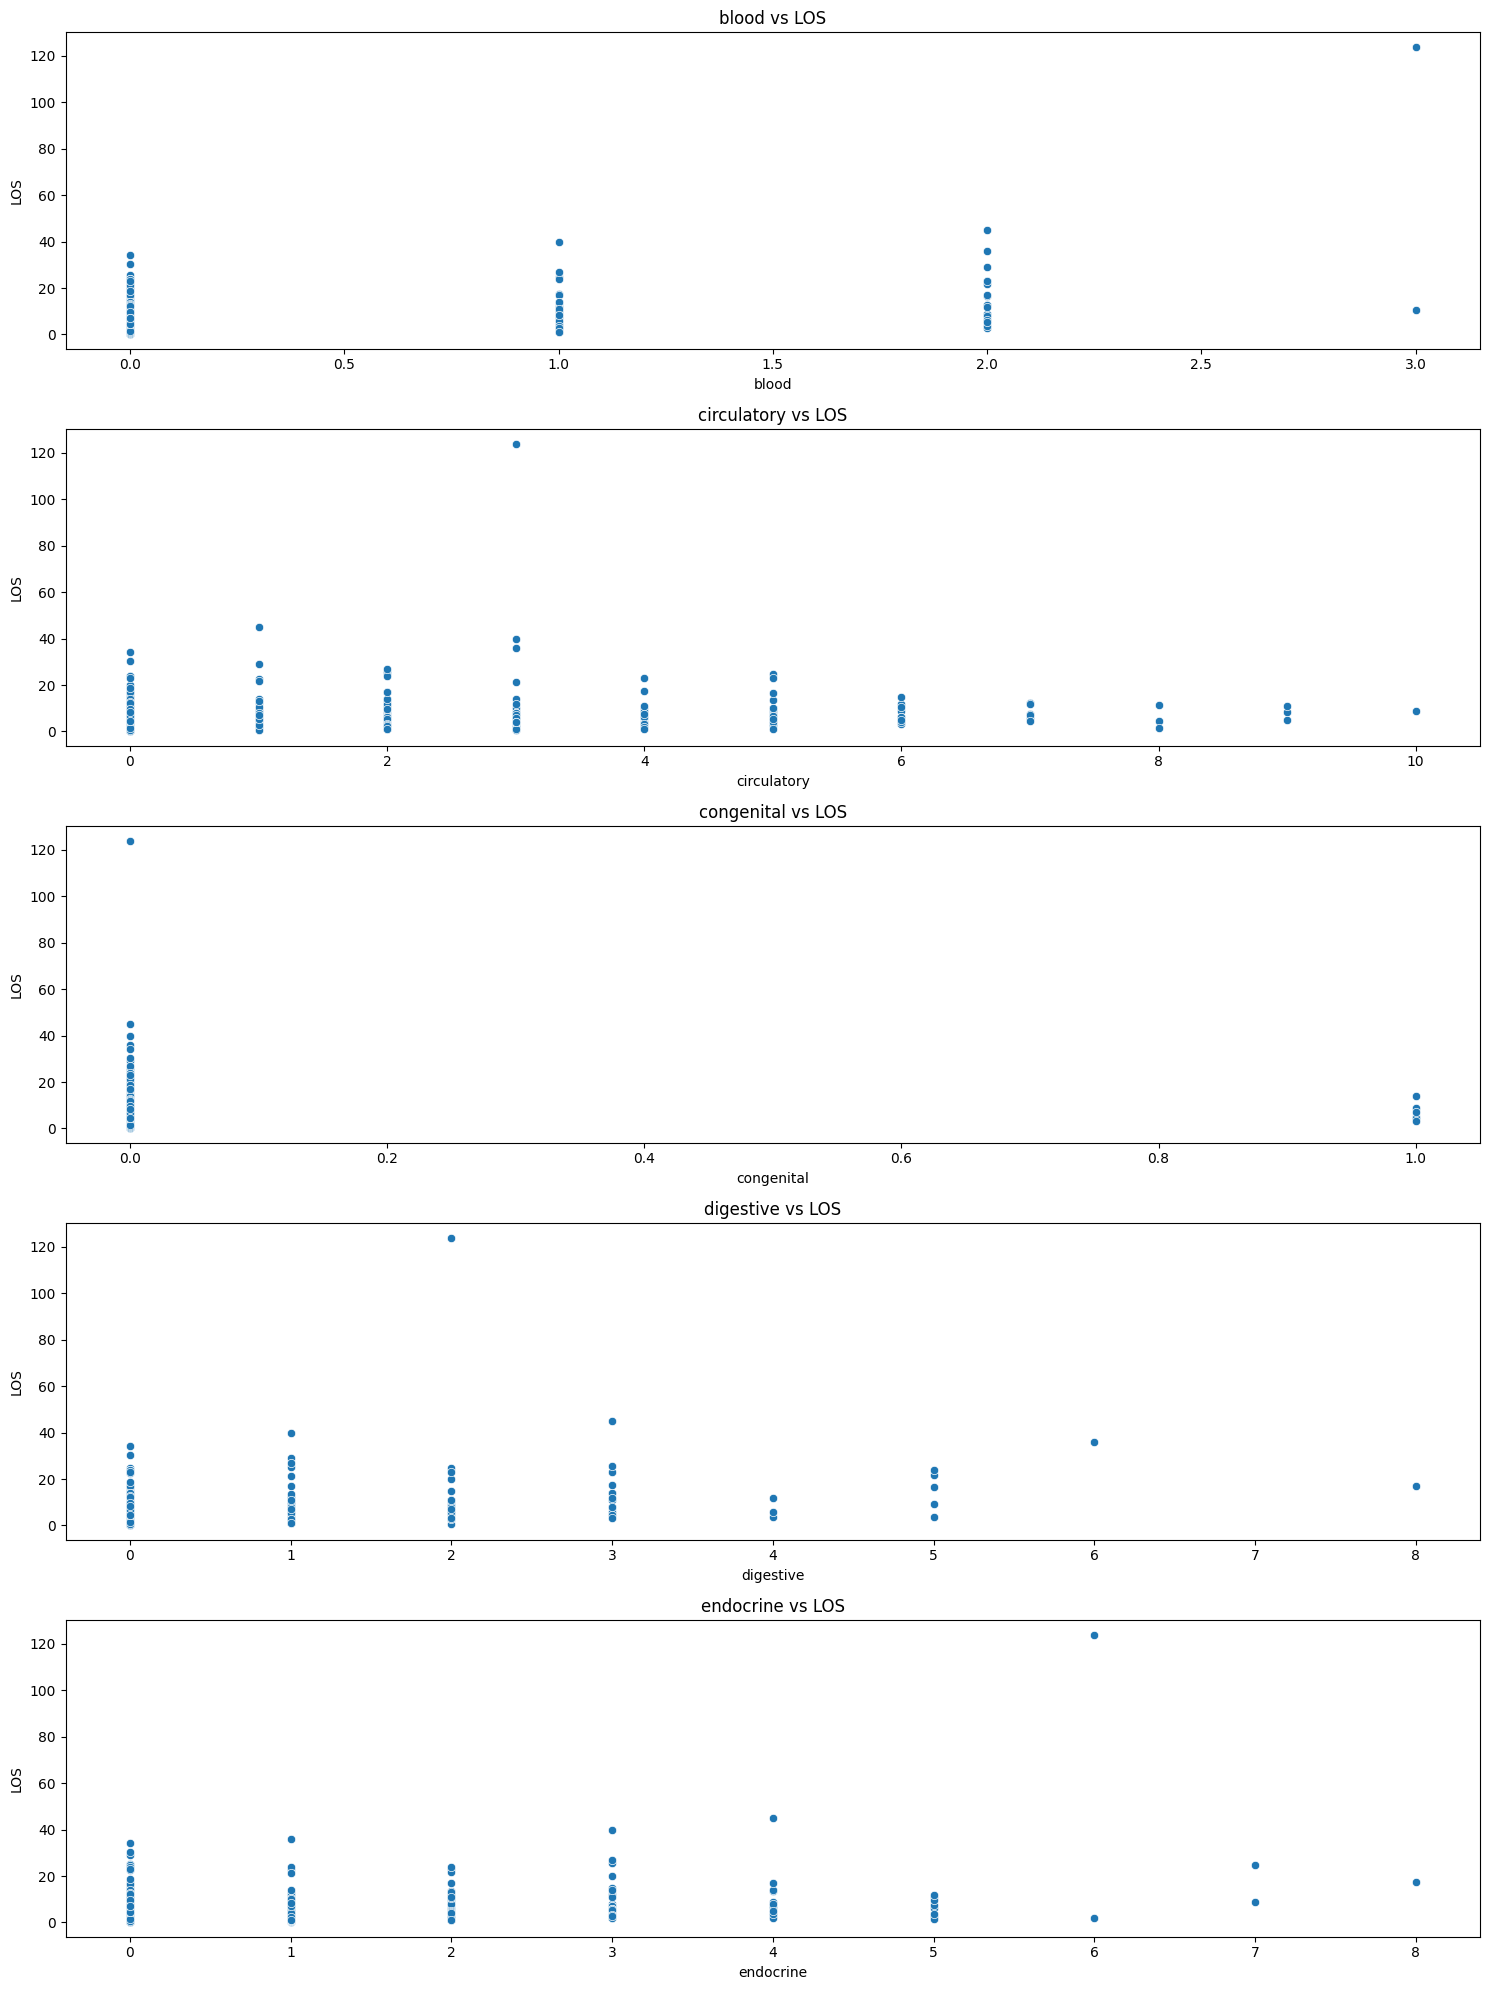

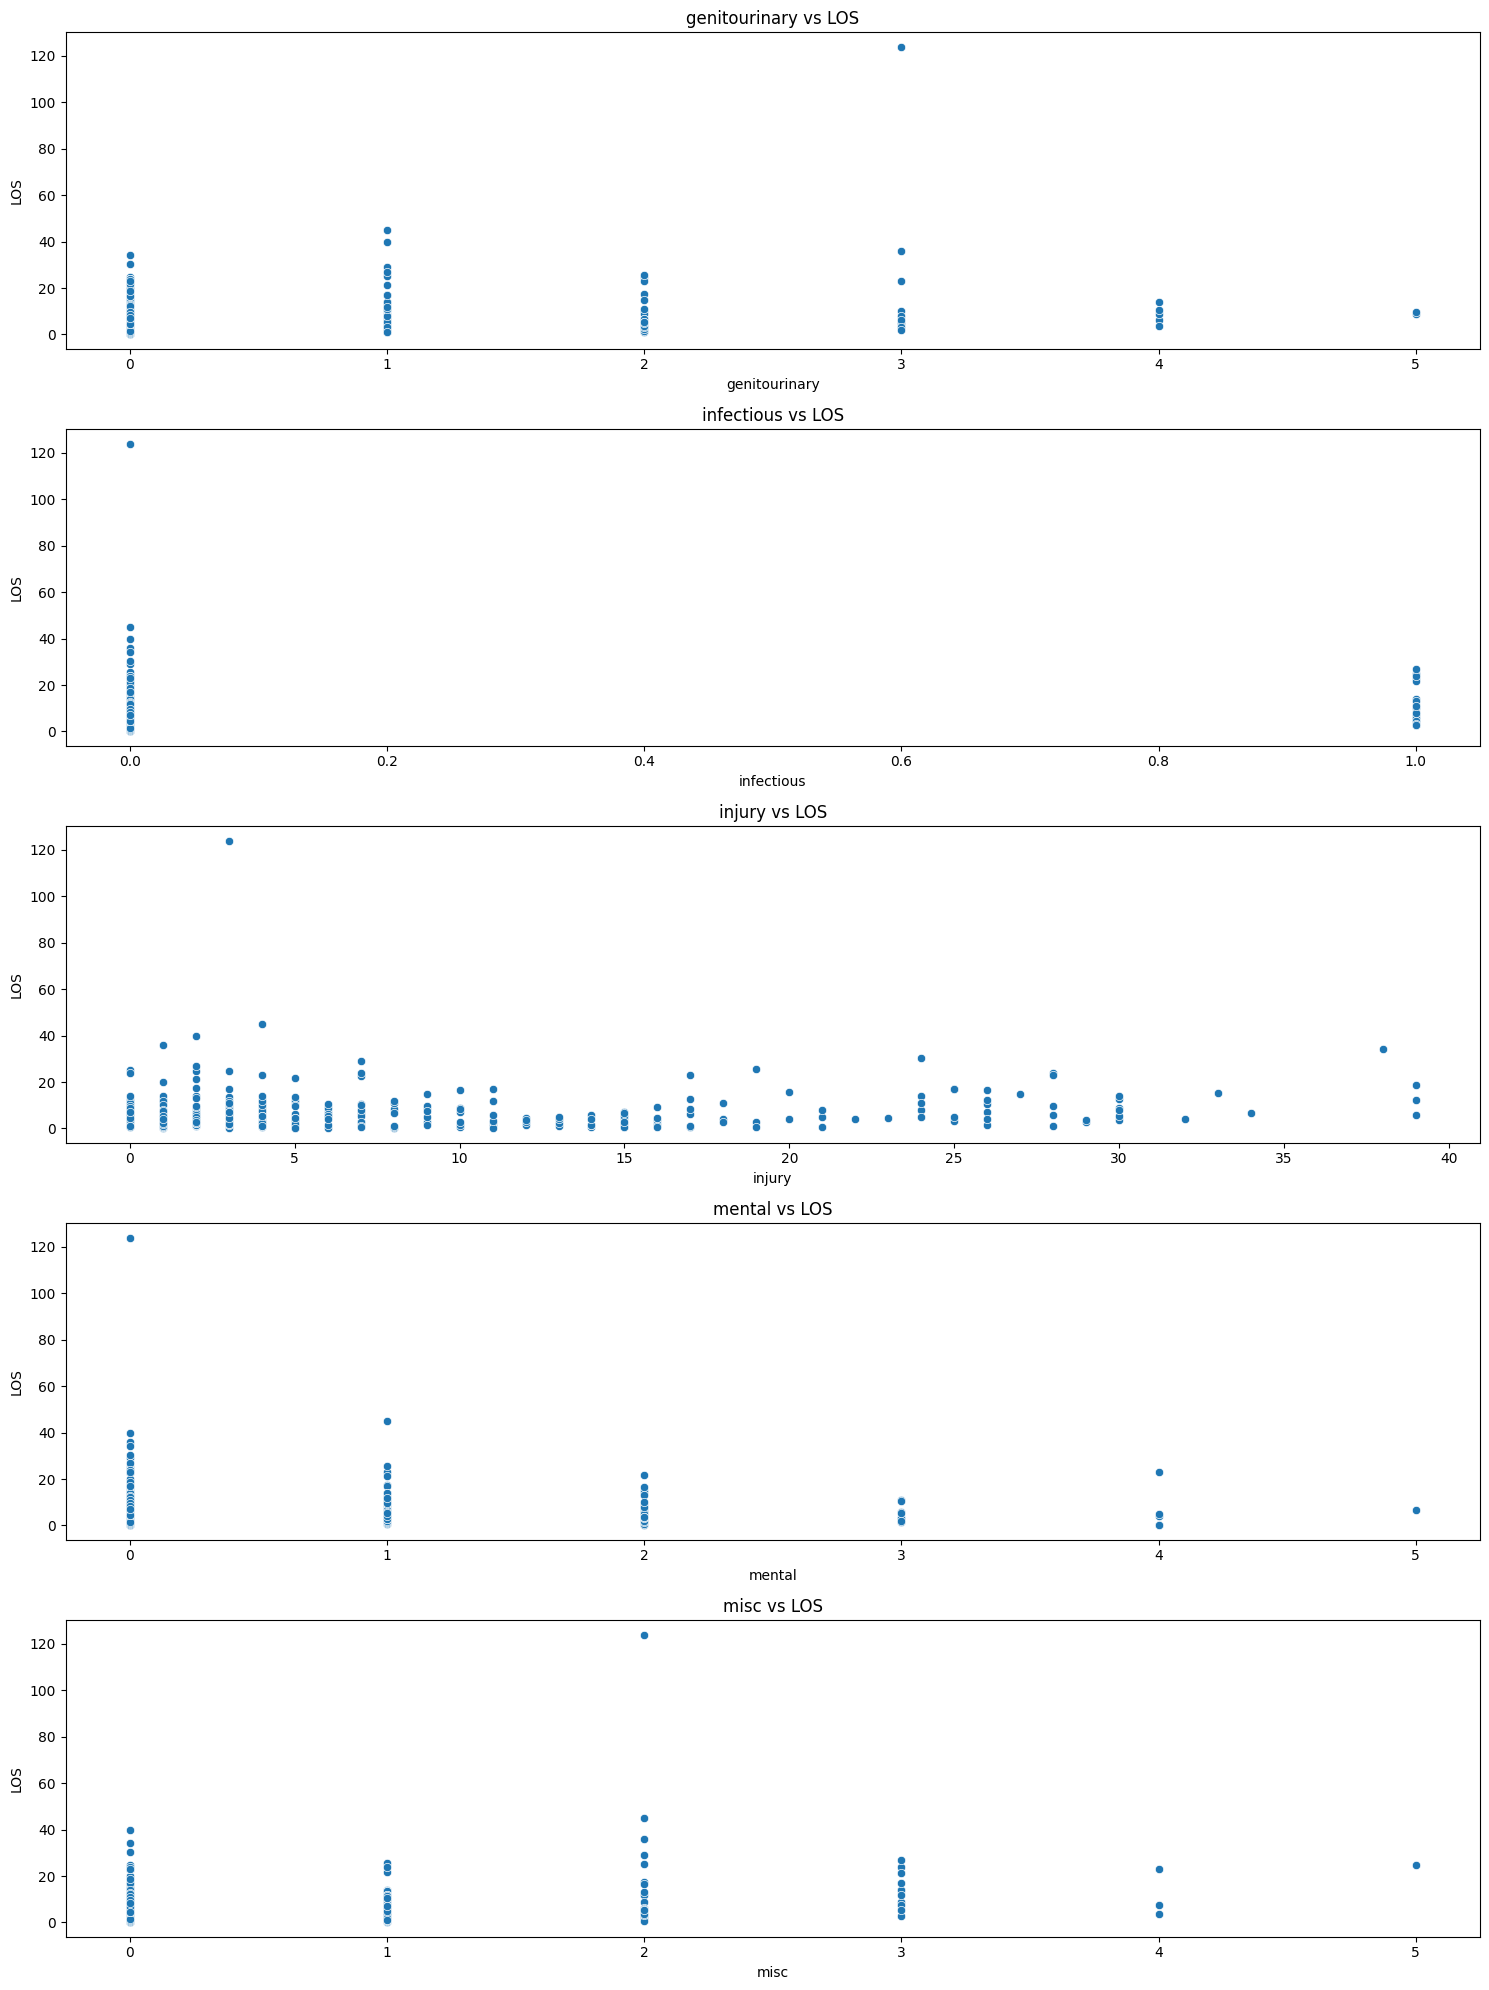

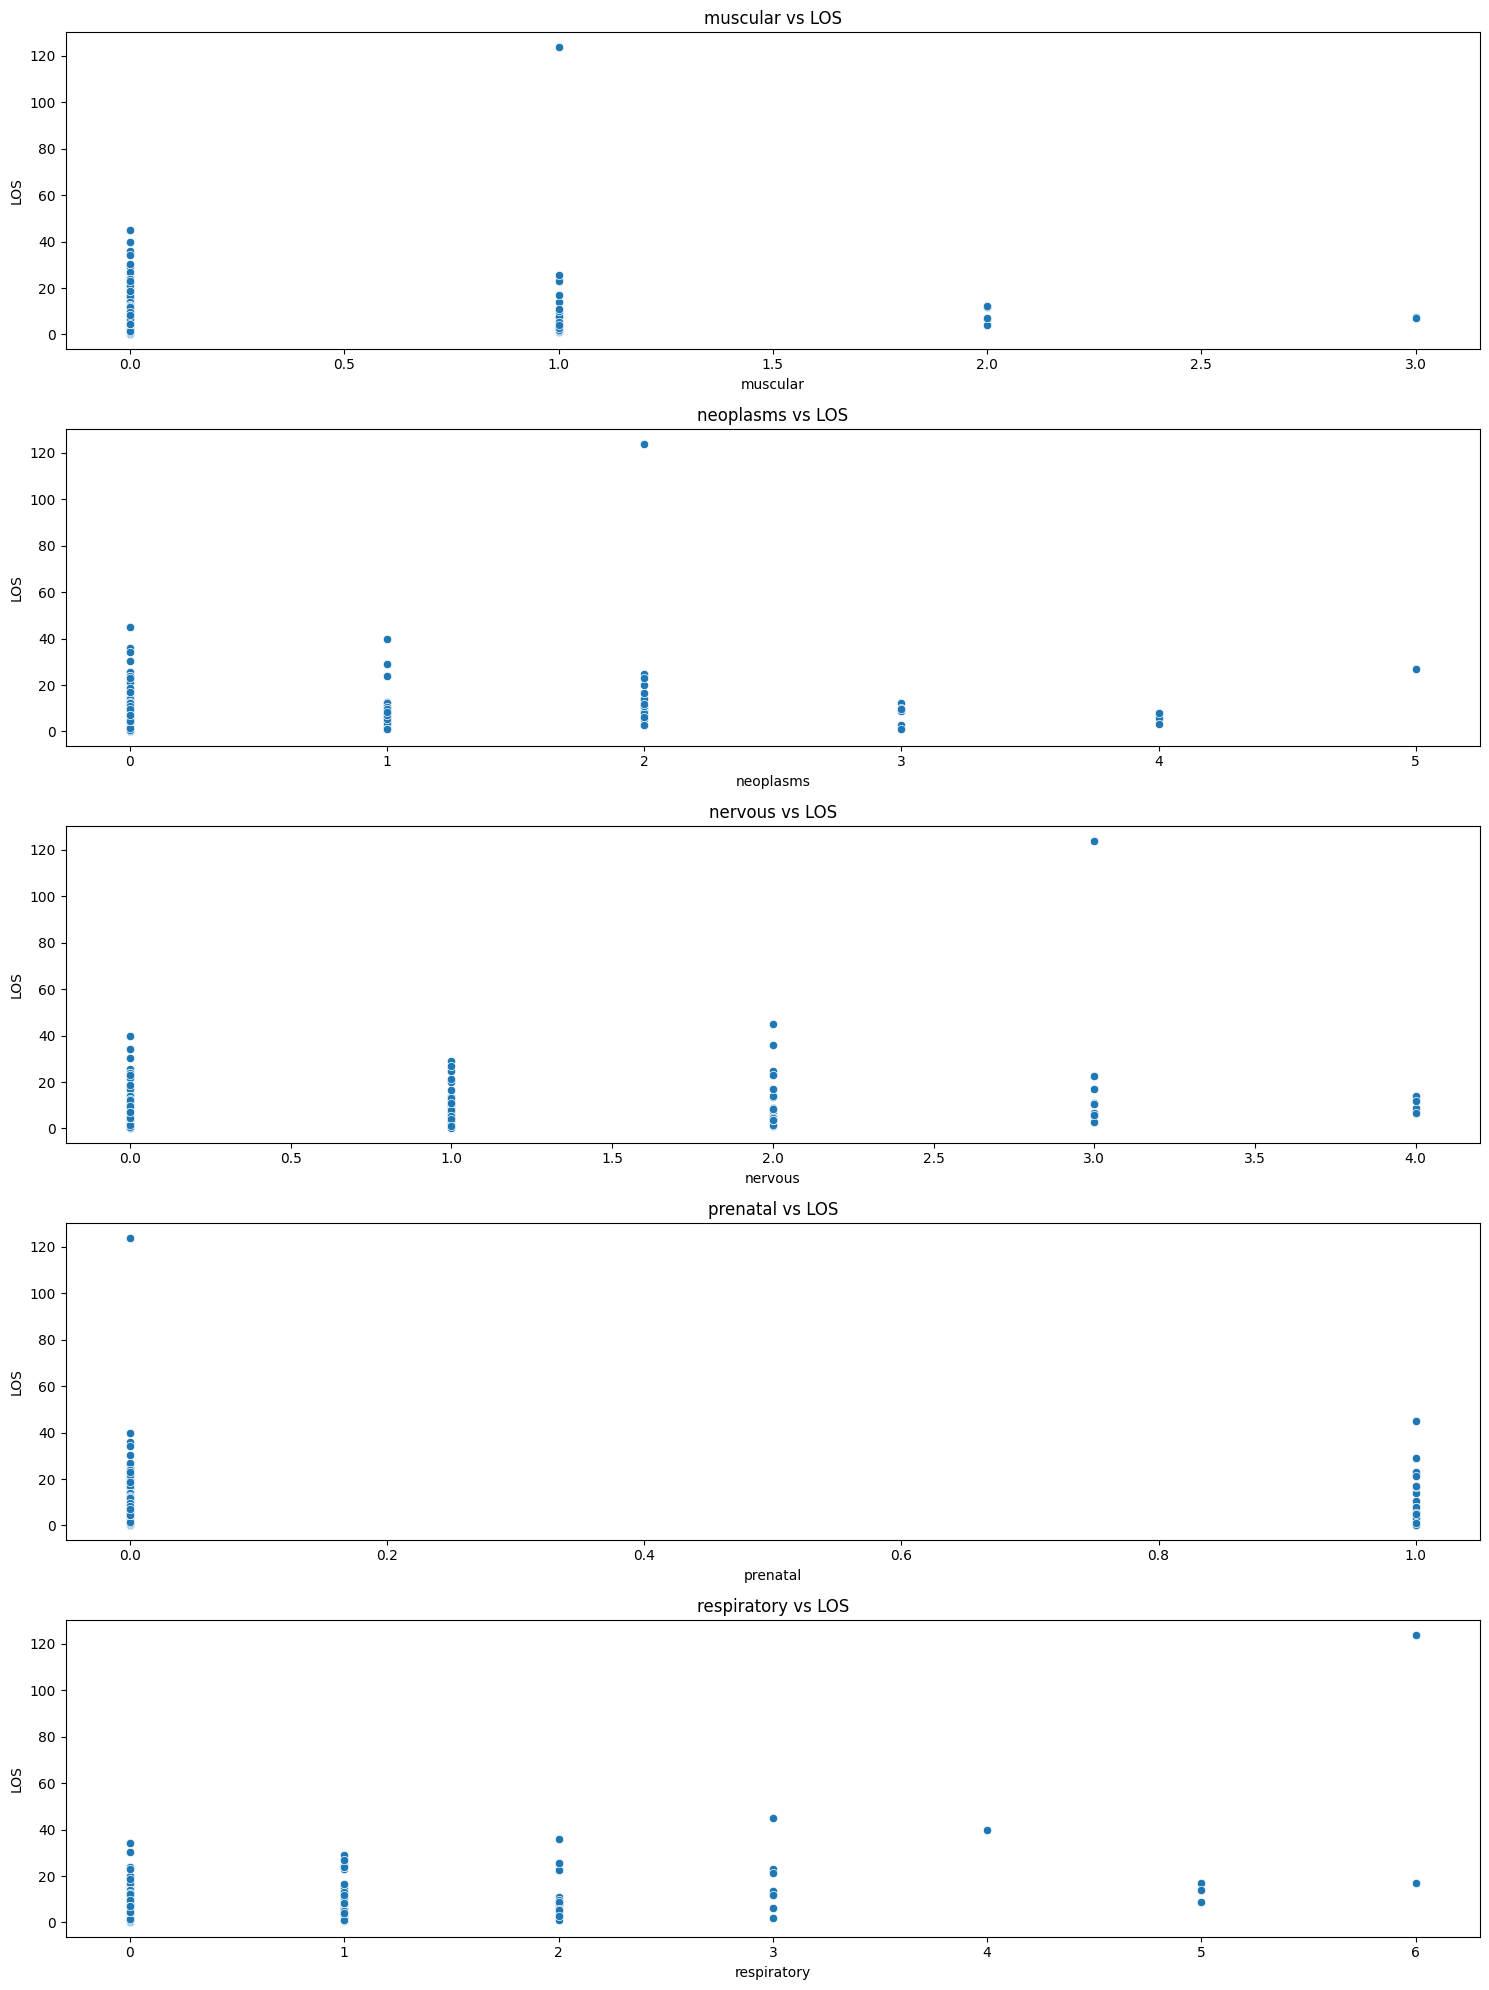

TypeError: 'value' must be an instance of str or bytes, not a float

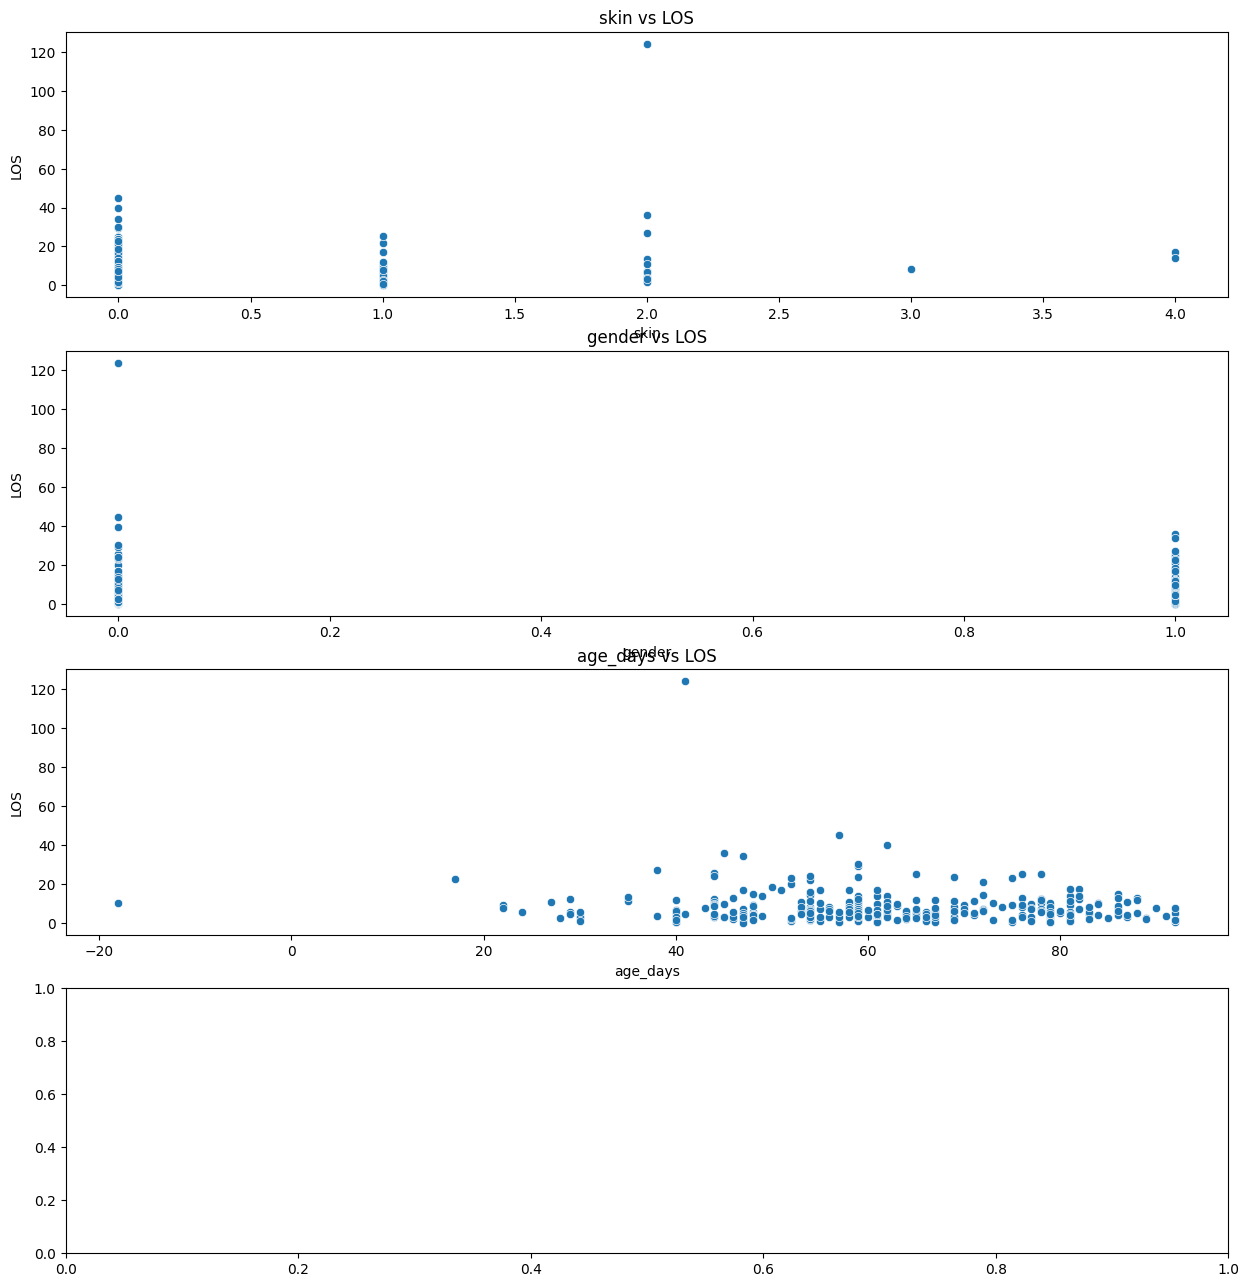

In [27]:
plot_feature_vs_target(df_clean, 'LOS')

In [64]:
import pandas as pd
import numpy as np

def strip_outliers(data, z_thresh=3):
    # Calculate z-scores for each column
    z_scores = np.abs((data - data.mean()) / data.std())
    
    # Determine outliers
    combined_outliers = z_scores > z_thresh
    
    # Print information about outliers if any
    if combined_outliers.any().any():
        # Get column names where any outliers are present
        outlier_columns = combined_outliers.any(axis=0)
        outlier_columns_names = data.columns[outlier_columns].tolist()
        print(f"Detected outliers in columns: {outlier_columns_names}")
        
        # Remove rows with outliers
        data_clean = data[~combined_outliers.any(axis=1)]
    else:
        print("No outliers detected!")
        data_clean = data
    
    return data_clean

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

def normalize_data(data, method='robust', **kwargs):
    
    # Ensure input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")
    
    original_columns = data.columns
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    elif method == 'log':
        # Ensure data does not contain negative values
        if (data <= 0).any().any():
            raise ValueError("Log transformation requires non-negative data.")
        normalized_data = np.log1p(data)  # log1p(x) is log(1 + x)
        return pd.DataFrame(normalized_data, columns=original_columns)
    elif method == 'power':
        scaler = PowerTransformer(**kwargs)  # **kwargs can be used to specify method ('box-cox' or 'yeo-johnson')
    elif method == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal', **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Apply the scaler
    normalized_data = scaler.fit_transform(data)
    
    # Return DataFrame with original columns
    return pd.DataFrame(normalized_data, columns=original_columns)



In [97]:
norm_df = normalize_data(df_clean, method='quantile')

c:\Users\nehas\OneDrive\Desktop\AI factory- LOS\.conda\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (338). n_quantiles is set to n_samples.
  warnings.warn(


In [78]:
print(type(norm_df))

<class 'pandas.core.frame.DataFrame'>


In [98]:
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   LOS                                         338 non-null    float64
 1   blood                                       338 non-null    float64
 2   circulatory                                 338 non-null    float64
 3   congenital                                  338 non-null    float64
 4   digestive                                   338 non-null    float64
 5   endocrine                                   338 non-null    float64
 6   genitourinary                               338 non-null    float64
 7   infectious                                  338 non-null    float64
 8   injury                                      338 non-null    float64
 9   mental                                      338 non-null    float64
 10  misc          

In [109]:
strip_df = strip_outliers(df_clean, z_thresh=4)

Detected outliers in columns: ['LOS', 'blood', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'respiratory', 'skin', 'age_days', 'admission_type_AMBULATORY OBSERVATION', 'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION', 'admission_type_Surgical same day admission', 'insurance_Private', 'religion_NOT SPECIFIED', 'religion_UNOBTAINABLE', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_UNKNOWN', 'age_-1.0', 'age_newborn']


In [106]:
strip_df.describe()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER/UNKNOWN,ethnicity_UNKNOWN,ethnicity_WHITE,age_-1.0,age_newborn
count,80.000000,80.000000,80.000000,80.0,80.000000,80.000000,80.000000,80.0,80.000000,80.000000,...,80.000000,80.0,80.000000,80.000000,80.0,80.0,80.0,80.000000,80.0,80.0
mean,7.388264,0.262500,1.237500,0.0,0.225000,0.800000,0.500000,0.0,12.425000,0.275000,...,0.475000,0.0,0.237500,0.200000,0.0,0.0,0.0,0.800000,0.0,1.0
std,5.829270,0.545262,1.773531,0.0,0.594809,1.236573,0.763072,0.0,10.921788,0.635948,...,0.502525,0.0,0.428236,0.402524,0.0,0.0,0.0,0.402524,0.0,0.0
min,0.993056,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0
25%,3.435938,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,1.0
50%,5.570139,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,8.500000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,1.0
75%,9.690278,0.000000,2.000000,0.0,0.000000,1.250000,1.000000,0.0,23.250000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,1.0
max,30.150694,2.000000,7.000000,0.0,3.000000,5.000000,3.000000,0.0,34.000000,3.000000,...,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,1.0


In [60]:
strip_df['age_days']

3      44.0
10     83.0
12     71.0
17     86.0
21     80.0
       ... 
393    85.0
395    61.0
396    61.0
397    79.0
401    48.0
Name: age_days, Length: 220, dtype: float64

In [61]:
strip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 3 to 401
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   LOS                                         220 non-null    float64
 1   blood                                       220 non-null    float64
 2   circulatory                                 220 non-null    float64
 3   congenital                                  220 non-null    float64
 4   digestive                                   220 non-null    float64
 5   endocrine                                   220 non-null    float64
 6   genitourinary                               220 non-null    float64
 7   infectious                                  220 non-null    float64
 8   injury                                      220 non-null    float64
 9   mental                                      220 non-null    float64
 10  misc               

In [110]:
LOS = strip_df['LOS'].values
# Prediction Features
features = strip_df.drop(columns=['LOS'])
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 176 samples.
Testing set has 44 samples.


SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


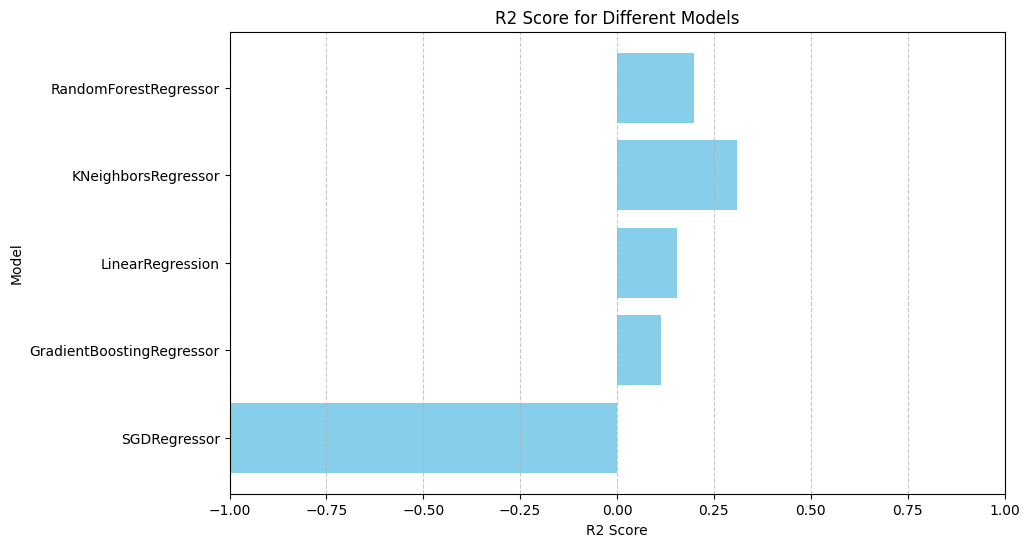

In [111]:
# Regression models for comparison
models = [
    SGDRegressor(random_state=0),
    GradientBoostingRegressor(random_state=0),
    LinearRegression(),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=0)
]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.title('R2 Score for Different Models')
plt.xlim(-1, 1)  # Set x-axis limits to include both positive and negative R2 values
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better visualization
plt.show()

In [114]:
reg_model = KNeighborsRegressor()   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.310643


In [115]:
import joblib

# Save the model
joblib.dump(reg_model, 'model.joblib')



['model.joblib']